# GPR to predict the number of atoms


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter
from sklearn.metrics import r2_score
import sklearn.gaussian_process as gp

In [2]:
df = pd.read_csv('mu_cn10000.csv')
df

,CN,Num Cu,Num Te,Mu1,Mu2,Mu3,Mu4,Mu5,Mu6,Mu7,...,Mu91,Mu92,Mu93,Mu94,Mu95,Mu96,Mu97,Mu98,Mu99,Mu100
0,9.920706,5.641016,4.279690,0.030303,0.032757,0.035112,0.037475,0.039958,0.042668,0.045714,...,0.994119,0.995957,0.998090,1.000540,1.003327,1.006472,1.009996,1.013918,1.018260,1.023043
1,9.038954,4.685766,4.353189,0.031529,0.034154,0.036671,0.039203,0.041875,0.044810,0.048132,...,0.999269,1.000942,1.002782,1.004773,1.006900,1.009148,1.011502,1.013947,1.016467,1.019047
2,9.725820,5.599930,4.125890,0.030576,0.033095,0.035505,0.037921,0.040456,0.043223,0.046335,...,0.994823,0.997591,1.000637,1.003974,1.007616,1.011577,1.015872,1.020514,1.025518,1.030897
3,9.374672,5.139779,4.234893,0.030891,0.033427,0.035861,0.038308,0.040883,0.043703,0.046883,...,0.999852,1.002114,1.004576,1.007246,1.010132,1.013241,1.016581,1.020158,1.023981,1.028057
4,9.599938,5.271755,4.328182,0.031077,0.033681,0.036170,0.038665,0.041287,0.044156,0.047393,...,0.998475,1.000035,1.001807,1.003776,1.005926,1.008242,1.010709,1.013311,1.016034,1.018861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9.360022,5.084340,4.275681,0.030950,0.033483,0.035915,0.038363,0.040943,0.043770,0.046960,...,1.001789,1.003715,1.005820,1.008111,1.010590,1.013262,1.016131,1.019201,1.022478,1.025964
9996,9.758551,5.435938,4.322612,0.030927,0.033519,0.035994,0.038473,0.041074,0.043918,0.047124,...,1.000563,1.002288,1.004220,1.006344,1.008645,1.011110,1.013723,1.016471,1.019338,1.022312
9997,10.181228,6.181228,4.000000,0.030587,0.033143,0.035582,0.038020,0.040572,0.043356,0.046485,...,0.992527,0.996200,1.000256,1.004671,1.009423,1.014490,1.019850,1.025479,1.031355,1.037456
9998,10.156260,6.020380,4.135880,0.030699,0.033247,0.035682,0.038120,0.040676,0.043465,0.046604,...,0.994741,0.997739,1.001036,1.004613,1.008451,1.012532,1.016838,1.021350,1.026048,1.030916


In [10]:
def GPR_get_CN(features, labels):
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
    # Import the model we are using
    kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
    gpr = model.fit(train_features, train_labels)
    params = model.kernel_.get_params()
    pred_labels, std = model.predict(test_features, return_std=True)
    MSE = ((pred_labels-test_labels)**2).mean()
    RMSE = MSE**(1/2)
    print('MSE = ', MSE)
    print('RMSE =', RMSE)
    rSquare = r2_score(test_labels, pred_labels)
    print('R Squared Error:', rSquare)
    return (RMSE, rSquare)

In [11]:
def xanes_derivatives(mu_df, dx=0.80808080808):
    '''
    xanes_derivatives calculates and returns the first and second derivative of a series of XANES spectra.
    Inputs:
        mu_df = Pandas dataframe of averaged XANES spectra absorption values.
        dx = distance between uniformly distributed energy values in XANES spectra. Defaulted to value provided in data.
    '''
    for nums in range(len(mu_df)):
        if nums == 0:
            pass

    dmu1 = np.zeros([len(mu_df), len(mu_df.columns)])
    dmu2 = np.zeros([len(mu_df), len(mu_df.columns)])
    if len(mu_df.columns) == 1000:
        dx =0.1*dx

    for i in range(len(mu_df)):
        for j in range(len(mu_df.columns)):
            if j == len(mu_df.columns)-1:
                pass
            else:
                dmu1[i, j] = (mu_df.iloc[i, j+1] - mu_df.iloc[i, j]) / dx

    for i_ in range(len(mu_df)):
        for j_ in range(len(mu_df.columns)):
            if j_ == len(mu_df.columns)-1:
                pass
            else:
                dmu2[i_, j_] = (dmu1[i_, j_+1] - dmu1[i_, j_]) / dx

    return dmu1, dmu2

In [12]:
def raw_spectra(df):

    features=np.array(df.loc[:,'Mu1':'Mu100'])
    
    return features

In [13]:
def one_demension_get_N_evenly_spaced_elements(arr, numElems):
    '''
    return nd.array
    '''
    idx = np.round(np.linspace(0, len(arr) - 1, numElems)).astype(int)
    return arr[idx]

In [14]:
def ndArray_get_N_evely_spaced_elements(after_smooth, numElems):
    ndArray_evenly_spaced=np.array([])
    for arr in after_smooth:
        a_row_evenly_spaced=one_demension_get_N_evenly_spaced_elements(arr, numElems)
        print(a_row_evenly_spaced)
        #ndArray_evenly_spaced=np.concatenate((ndArray_evenly_spaced, [a_row_evenly_spaced]),axis=0)
        ndArray_evenly_spaced  = np.append(ndArray_evenly_spaced, a_row_evenly_spaced, axis=0)
    return ndArray_evenly_spaced.reshape(len(after_smooth),numElems)

In [17]:
def setSize_vs_error (size_list, df):
    spectrum_data = []
    dmu1_data = []
    dmu2_data = []
    dmu_both_data = []
    for entry in size_list:
        df_sample = df.sample(entry, random_state=26)
        raw_df_sample = raw_spectra(df_sample)
        dmu1, dmu2 =xanes_derivatives(pd.DataFrame(raw_df_sample))
        dmu_both= np.concatenate((dmu1,dmu2),axis=1)
        print('set size =', entry)
        print('spectrum')
        spectrum_data.append(GPR_get_CN(features = raw_df_sample, labels = np.array(df_sample['CN'])))
        print('dmu1')
        dmu1_data.append(GPR_get_CN(features = dmu1, labels = np.array(df_sample['CN'])))        
        print('dmu2')
        dmu2_data.append(GPR_get_CN(features = dmu2, labels = np.array(df_sample['CN'])))
        print('dmu_both')
        dmu_both_data.append(GPR_get_CN(features = dmu_both, labels = np.array(df_sample['CN'])))

    return (spectrum_data, dmu1_data, dmu2_data, dmu_both_data)

In [18]:
size_list = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
setSize_vs_error(size_list, df)

set size = 500
spectrum
MSE =  0.004001648152533378
RMSE = 0.0632585816512936
R Squared Error: 0.9828843106598892
dmu1
MSE =  0.0021865447360885568
RMSE = 0.046760504018760925
R Squared Error: 0.9906477983559215
dmu2
MSE =  0.004095841929701424
RMSE = 0.06399876506387779
R Squared Error: 0.9824814288056315
dmu_both
MSE =  0.002240684671685107
RMSE = 0.047335870877011514
R Squared Error: 0.9904162331899592
set size = 1000
spectrum
MSE =  0.0030808606148532585
RMSE = 0.05550550076211599
R Squared Error: 0.98450493791682
dmu1
MSE =  0.002012869258442491
RMSE = 0.044865011517244605
R Squared Error: 0.9898763566340776
dmu2
MSE =  0.0028481864951971606
RMSE = 0.05336840352865317
R Squared Error: 0.9856751628571626
dmu_both
MSE =  0.001982675087275982
RMSE = 0.044527239834465174
R Squared Error: 0.9900282169793719
set size = 2000
spectrum
MSE =  0.0019950491724969256
RMSE = 0.044665973318589236
R Squared Error: 0.9878789271534331
dmu1
MSE =  0.0012405473893300847
RMSE = 0.035221405271937754
R

/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.64467851e+00,  1.17978054e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


MSE =  0.0012918407627215596
RMSE = 0.03594218639317257
R Squared Error: 0.9931420824088638
dmu_both
MSE =  0.0008738708613212651
RMSE = 0.029561306827020774
R Squared Error: 0.9953609341606383
set size = 4000
spectrum
MSE =  0.0014492640717191105
RMSE = 0.03806920109115912
R Squared Error: 0.991971304482665
dmu1
MSE =  0.000739025783324355
RMSE = 0.02718502866145914
R Squared Error: 0.9959059131392576
dmu2
MSE =  0.0009737780291423249
RMSE = 0.031205416663494894
R Squared Error: 0.9946054225382263
dmu_both
MSE =  0.0006934330755676597
RMSE = 0.026333117467699483
R Squared Error: 0.9961584895851465
set size = 5000
spectrum
MSE =  0.0012202572483585637
RMSE = 0.03493218069858456
R Squared Error: 0.9935885407029149
dmu1
MSE =  0.0007506377463497482
RMSE = 0.02739776900314601
R Squared Error: 0.9960560092029358
dmu2
MSE =  0.0008940803551301144
RMSE = 0.029901176484046818
R Squared Error: 0.995302334968343
dmu_both


/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.68179681e+00,  5.26220906e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


MSE =  0.0006993947889237285
RMSE = 0.02644607322314087
R Squared Error: 0.9963252492637845
set size = 6000
spectrum
MSE =  0.0011787106025157087
RMSE = 0.03433235503888
R Squared Error: 0.9935202690683262
dmu1
MSE =  0.0007779971828042737
RMSE = 0.027892600861236905
R Squared Error: 0.9957231126966938
dmu2
MSE =  0.0008963431595256557
RMSE = 0.029938990623026282
R Squared Error: 0.9950725288431473
dmu_both
MSE =  0.0007366872061042378
RMSE = 0.02714198235398877
R Squared Error: 0.9959502062116232
set size = 7000
spectrum


/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.67562897e+00, -7.00101850e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


MSE =  0.0010024930674572294
RMSE = 0.03166217092142024
R Squared Error: 0.9948415286134987
dmu1
MSE =  0.0007034372018799956
RMSE = 0.02652239057626585
R Squared Error: 0.9963803633203147
dmu2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.53781561e+00,  9.93167731e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


MSE =  0.0008513168325707683
RMSE = 0.02917733422660076
R Squared Error: 0.9956194275409784
dmu_both


/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.19298711e+00,  4.42447938e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


MSE =  0.0006709091096272079
RMSE = 0.02590191324260059
R Squared Error: 0.9965477412689413
set size = 8000
spectrum
MSE =  0.0009499055752563432
RMSE = 0.030820538205169994
R Squared Error: 0.9950821347206247
dmu1
MSE =  0.0007020303232747531
RMSE = 0.026495854831930843
R Squared Error: 0.9963654381637145
dmu2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.96203478e+00,  1.79269230e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


MSE =  0.0007933272519784239
RMSE = 0.028166065610560946
R Squared Error: 0.9958927743458774
dmu_both
MSE =  0.0006681415073543947
RMSE = 0.02584843336363724
R Squared Error: 0.996540887845783
set size = 9000
spectrum
MSE =  0.0009155471421375256
RMSE = 0.030258009553464114
R Squared Error: 0.9955056407322306
dmu1
MSE =  0.0006492461606554387
RMSE = 0.025480309273151272
R Squared Error: 0.9968128943176067
dmu2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.32459226e+00,  1.24731253e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


MSE =  0.0006964670773556698
RMSE = 0.026390662692620467
R Squared Error: 0.9965810900173838
dmu_both
MSE =  0.0006122086528618383
RMSE = 0.024742850540344745
R Squared Error: 0.9969947089492581
set size = 10000
spectrum
MSE =  0.0009559046932860495
RMSE = 0.030917708409357404
R Squared Error: 0.9950081526999007
dmu1
MSE =  0.0007094526480548994
RMSE = 0.02663555233245407
R Squared Error: 0.9962951544117157
dmu2
MSE =  0.0007200743353366538
RMSE = 0.026834200851462927
R Squared Error: 0.9962396867052044
dmu_both
MSE =  0.0006675122868389891
RMSE = 0.025836259149478066
R Squared Error: 0.9965141719355036


([(0.0632585816512936, 0.9828843106598892),
  (0.05550550076211599, 0.98450493791682),
  (0.044665973318589236, 0.9878789271534331),
  (0.04151941051445821, 0.9908486400954845),
  (0.03806920109115912, 0.991971304482665),
  (0.03493218069858456, 0.9935885407029149),
  (0.03433235503888, 0.9935202690683262),
  (0.03166217092142024, 0.9948415286134987),
  (0.030820538205169994, 0.9950821347206247),
  (0.030258009553464114, 0.9955056407322306),
  (0.030917708409357404, 0.9950081526999007)],
 [(0.046760504018760925, 0.9906477983559215),
  (0.044865011517244605, 0.9898763566340776),
  (0.035221405271937754, 0.9924629600698669),
  (0.03037701025209893, 0.9951013847131844),
  (0.02718502866145914, 0.9959059131392576),
  (0.02739776900314601, 0.9960560092029358),
  (0.027892600861236905, 0.9957231126966938),
  (0.02652239057626585, 0.9963803633203147),
  (0.026495854831930843, 0.9963654381637145),
  (0.025480309273151272, 0.9968128943176067),
  (0.02663555233245407, 0.9962951544117157)],
 [(0.

In [24]:
spectrum_data = [(0.0632585816512936, 0.9828843106598892),(0.05550550076211599, 0.98450493791682),(0.044665973318589236, 0.9878789271534331),(0.04151941051445821, 0.9908486400954845),(0.03806920109115912, 0.991971304482665),(0.03493218069858456, 0.9935885407029149),(0.03433235503888, 0.9935202690683262),(0.03166217092142024, 0.9948415286134987),(0.030820538205169994, 0.9950821347206247),(0.030258009553464114, 0.9955056407322306),(0.030917708409357404, 0.9950081526999007)]
dmu1_data = [(0.046760504018760925, 0.9906477983559215),(0.044865011517244605, 0.9898763566340776),(0.035221405271937754, 0.9924629600698669),(0.03037701025209893, 0.9951013847131844),(0.02718502866145914, 0.9959059131392576),(0.02739776900314601, 0.9960560092029358),(0.027892600861236905, 0.9957231126966938),(0.02652239057626585, 0.9963803633203147),(0.026495854831930843, 0.9963654381637145),(0.025480309273151272, 0.9968128943176067),(0.02663555233245407, 0.9962951544117157)]
dmu2_data = [(0.06399876506387779, 0.9824814288056315),(0.05336840352865317, 0.9856751628571626),(0.04049550249833509, 0.9900367496813559),(0.03594218639317257, 0.9931420824088638),(0.031205416663494894, 0.9946054225382263),(0.029901176484046818, 0.995302334968343),(0.029938990623026282, 0.9950725288431473),(0.02917733422660076, 0.9956194275409784),(0.028166065610560946, 0.9958927743458774),(0.026390662692620467, 0.9965810900173838),(0.026834200851462927, 0.9962396867052044)]
dmu_both_data = [(0.047335870877011514, 0.9904162331899592),(0.044527239834465174, 0.9900282169793719),(0.034435855851819526, 0.9927954108555394),(0.029561306827020774, 0.9953609341606383),(0.026333117467699483, 0.9961584895851465),(0.02644607322314087, 0.9963252492637845),(0.02714198235398877, 0.9959502062116232),(0.02590191324260059, 0.9965477412689413),(0.02584843336363724, 0.996540887845783),(0.024742850540344745, 0.9969947089492581),(0.025836259149478066, 0.9965141719355036)]

In [30]:
spectrum_RMSE = []
spectrum_R2 = []
for entry in spectrum_data:
    spectrum_RMSE.append(entry[0])
    spectrum_R2.append(entry[1])
dmu1_RMSE = []
dmu1_R2 = []
for entry in dmu1_data:
    dmu1_RMSE.append(entry[0])
    dmu1_R2.append(entry[1])
dmu2_RMSE = []
dmu2_R2 = []
for entry in dmu2_data:
    dmu2_RMSE.append(entry[0])
    dmu2_R2.append(entry[1])
dmu_both_RMSE = []
dmu_both_R2 = []
for entry in dmu_both_data:
    dmu_both_RMSE.append(entry[0])
    dmu_both_R2.append(entry[1])

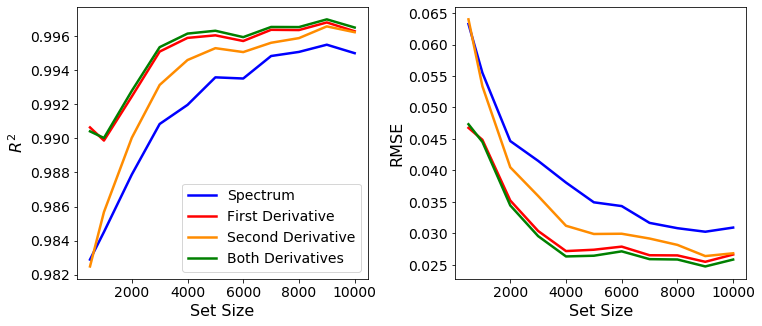

In [31]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, spectrum_R2, c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, dmu1_R2, c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, dmu2_R2, c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, dmu_both_R2, c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Set Size', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, spectrum_RMSE, c='blue', lw=2.5)
ax2.plot(size_list, dmu1_RMSE, c='red', lw=2.5)
ax2.plot(size_list, dmu2_RMSE, c='darkorange', lw=2.5)
ax2.plot(size_list, dmu_both_RMSE, c='green', lw=2.5)
ax2.set_xlabel('Set Size', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()